In [1]:
import math
import numpy as np
from matplotlib import pyplot as plt

from pyspark.mllib.linalg import Vectors
from pyspark.sql import SparkSession

from scalable_gps.gp import GaussianProcess

In [2]:
def test_func(x):
    return np.sin(x)

In [82]:
x_plot = np.linspace(-10, 10, 100)
y_plot = test_func(x_plot)

x_points = (np.random.random((10, 1)) - 0.5) * 20
y_points = test_func(x_points.squeeze())

In [83]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [84]:
x_points_par = sc.parallelize(x_points).map(lambda x: Vectors.dense(x))
x_points_par.cache()
y_points_par = sc.parallelize(y_points)
y_points_par.cache()

ParallelCollectionRDD[417] at readRDDFromFile at PythonRDD.scala:274

In [85]:
gp = GaussianProcess(x=x_points_par, y=y_points_par, lengthscales=Vectors.dense(np.ones(1)), sc=sc)

In [86]:
mean1, var1 = gp.predict_mean_var(sc.parallelize(x_plot).map(lambda x: Vectors.dense(x)))

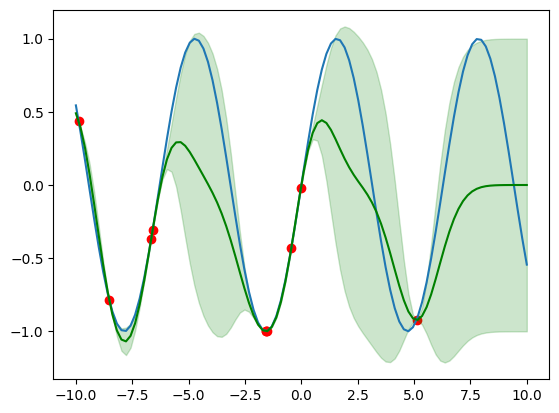

In [90]:
plt.plot(x_plot, y_plot)
plt.scatter(x_points, y_points, c="r", label)
plt.plot(x_plot, mean1, c="g", label="GP")
plt.fill_between(x_plot, mean1-var1, mean1+var1, color="g", alpha=0.2)